# Проект "Принятие решений в бизнесе"
## Описание:
Изображаем аналитика крупного интернет-магазина. Вместе с отделом маркетинга был подготовлен список гипотез для увеличения выручки. 

Необходимо приоритизировать гипотезы, запустить A/B-тест и проанализировать результаты.

### Ход исследования:
1)  Приоритизация гипотез методами ICE и RICE
 
2) Анализ A/B - теста: 

  - графики кумулятивного среднего чека и кумулятивной выручки по группам
  - график относительного изменения кумулятивного среднего чека группы B к группе A
  - график кумулятивной конверсии по группам и график относительного изменения кумулятивной конверсии группы B к группе A. 
  - точечный график количества заказов по пользователям и точечный график стоимостей заказов     
  - расчёт перцентилей количества заказов на пользователя и  стоимости заказов
  - расчёт статистической значимости различий в конверсии и в среднем чеке заказа между группами по «сырым» данным     
  - расчёт статистической значимости различий в конверсии и в среднем чеке заказа между группами по «очищенным» данным   
  - решение о результате А/B - теста

## Подключение библиотек, чтение файлов

In [39]:
import pandas as pd
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
import warnings
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import scipy.stats as stats

In [40]:
hyp =pd.read_csv('/datasets/hypothesis.csv')
orders= pd.read_csv('/datasets/orders.csv')
visitors=pd.read_csv('/datasets/visitors.csv')

## Предобработка

In [41]:
hyp.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Hypothesis  9 non-null      object
 1   Reach       9 non-null      int64 
 2   Impact      9 non-null      int64 
 3   Confidence  9 non-null      int64 
 4   Efforts     9 non-null      int64 
dtypes: int64(4), object(1)
memory usage: 488.0+ bytes


In [42]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   transactionId  1197 non-null   int64 
 1   visitorId      1197 non-null   int64 
 2   date           1197 non-null   object
 3   revenue        1197 non-null   int64 
 4   group          1197 non-null   object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB


In [43]:
visitors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   date      62 non-null     object
 1   group     62 non-null     object
 2   visitors  62 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 1.6+ KB


In [44]:
#Приведём названия столбцов к snake_style, и столбцы с датой - к нужному формату.
hyp.columns=hyp.columns.str.lower()
orders.rename(columns={'transactionId': 'transaction_id', 'visitorId': 'visitor_id'}, inplace=True)

In [45]:
visitors['date'] = pd.to_datetime(visitors['date'])
orders['date'] = pd.to_datetime(orders['date'])

In [46]:
#Проверим на наличие дубликатов
display(hyp.duplicated().sum())
display(orders.duplicated().sum())
visitors.duplicated().sum()

0

0

0

In [47]:
hyp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   hypothesis  9 non-null      object
 1   reach       9 non-null      int64 
 2   impact      9 non-null      int64 
 3   confidence  9 non-null      int64 
 4   efforts     9 non-null      int64 
dtypes: int64(4), object(1)
memory usage: 488.0+ bytes


In [48]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   transaction_id  1197 non-null   int64         
 1   visitor_id      1197 non-null   int64         
 2   date            1197 non-null   datetime64[ns]
 3   revenue         1197 non-null   int64         
 4   group           1197 non-null   object        
dtypes: datetime64[ns](1), int64(3), object(1)
memory usage: 46.9+ KB


In [49]:
visitors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   date      62 non-null     datetime64[ns]
 1   group     62 non-null     object        
 2   visitors  62 non-null     int64         
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 1.6+ KB


#### Вывод
Итак, нужные файлы загружены, проверены на наличие пропусков и дубликатов (оные не обнаружены),  названия столбцов приведены к стилю snake,  данные в столбцах, связаннных с датой и временем, переведены в формат datetime

## Приоритизация гипотез методами ICE и RICE

### Метод ICE
$$ICE = \frac{Impact * Confidence}{Efforts}$$


In [52]:
hyp['ICE']=round(hyp['impact']*hyp['confidence']/hyp['efforts'],1)
hyp[['hypothesis','ICE']].sort_values(by='ICE', ascending=False)

,hypothesis,ICE
8,"Запустить акцию, дающую скидку на товар в день...",16.2
0,"Добавить два новых канала привлечения трафика,...",13.3
7,Добавить форму подписки на все основные страни...,11.2
6,Показать на главной странице баннеры с актуаль...,8.0
2,Добавить блоки рекомендаций товаров на сайт ин...,7.0
1,"Запустить собственную службу доставки, что сок...",2.0
5,"Добавить страницу отзывов клиентов о магазине,...",1.3
3,"Изменить структура категорий, что увеличит кон...",1.1
4,"Изменить цвет фона главной страницы, чтобы уве...",1.0


Наиболее перспективные гипотезы по методу ICE - акция на товар в день рождения, 2 новых канала привлечения трафика, форма подписки на основные страницы  и  баннеры на главной странице.

### Метод RICE
$$RICE = \frac{Rearch * Impact * Confidence}{Efforts}$$

In [53]:
hyp['RICE']=hyp['reach']*hyp['impact']*hyp['confidence']/hyp['efforts']
hyp[['hypothesis','RICE']].sort_values(by='RICE', ascending=False)

,hypothesis,RICE
7,Добавить форму подписки на все основные страни...,112.0
2,Добавить блоки рекомендаций товаров на сайт ин...,56.0
0,"Добавить два новых канала привлечения трафика,...",40.0
6,Показать на главной странице баннеры с актуаль...,40.0
8,"Запустить акцию, дающую скидку на товар в день...",16.2
3,"Изменить структура категорий, что увеличит кон...",9.0
1,"Запустить собственную службу доставки, что сок...",4.0
5,"Добавить страницу отзывов клиентов о магазине,...",4.0
4,"Изменить цвет фона главной страницы, чтобы уве...",3.0


Наиболее перспективные гипотезы по методу RICE - Добавить форму подписки на основные страницы, добавить блоки рекомендаций товаров, добавить два новых канала привлечения трафика, показать на главной странице баннеры. (7, 2, 0, 6)

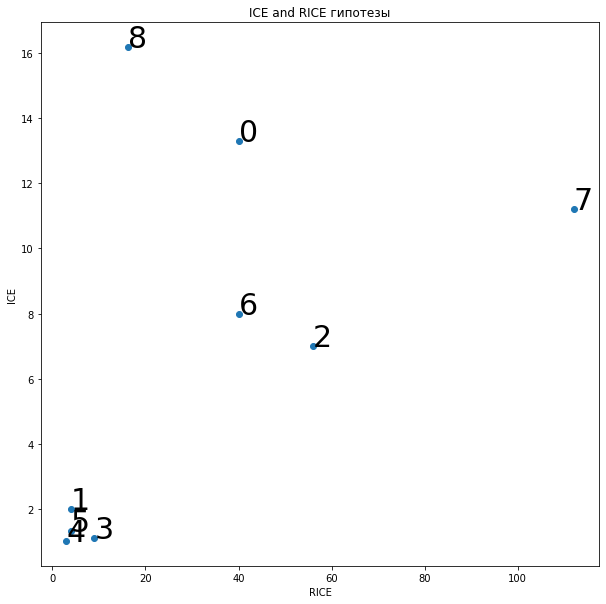

In [54]:
y = hyp['ICE'] 
z = hyp['RICE'] 
n = hyp.index 

fig, ax = plt.subplots()
ax.scatter(z, y)

for i, txt in enumerate(n):
    ax.annotate(txt, (z[i], y[i]), size=30)

plt.title("ICE and RICE гипотезы") 
plt.xlabel("RICE") 
plt.ylabel("ICE")

fig.set_figheight(10)
fig.set_figwidth(10) 
plt.show() 

### Вывод
Т.к в методе RICE учитывается и количество пользователей, которых затронет изменение (очевидно, акция в день рождения затрагивает очень малое число людей,  а блоки рекомендаций товаров - очень большое), будем основываться именно на нём.

Итак, будем считать наиболее перспективными следующие предложения: 
- Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок
- Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа
- Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей
- Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию

## Анализ А/В-теста

### Графики кумулятивного среднего чека и кумулятивной выручки по группам

In [55]:
#Cоздадим датафрейм пар значений дат и групп теста
date_groups = orders[['date','group']].drop_duplicates() 

In [56]:
 #Соберём агрегированные кумулятивные по дням данные о заказах и о пользователях
ord_agg= date_groups.apply(lambda x: orders[np.logical_and(orders['date'] <= x['date'], orders['group'] == x['group'])]
.agg(
    {'date' : 'max', 'group' : 'max', 'transaction_id' : 'nunique', 'visitor_id' : 'nunique', 'revenue' : 'sum'}), axis=1
                          ).sort_values(by=['date','group'])


vis_agg=date_groups.apply(lambda x: visitors[np.logical_and(visitors['date'] <= x['date'], 
                                                               visitors['group'] == x['group'])]
                                       .agg({'date' : 'max', 'group' : 'max', 'visitors' : 'sum'}), axis=1
                         ).sort_values(by=['date','group'])

In [57]:
#Объединим в удобную таблицу
cumulative_data = ord_agg.merge(vis_agg, left_on=['date', 'group'], right_on=['date', 'group'])
cumulative_data.columns = ['date', 'group', 'orders', 'buyers', 'revenue', 'visitors']
cumulative_data.head()

,date,group,orders,buyers,revenue,visitors
0,2019-08-01,A,24,20,148579,719
1,2019-08-01,B,21,20,101217,713
2,2019-08-02,A,44,38,242401,1338
3,2019-08-02,B,45,43,266748,1294
4,2019-08-03,A,68,62,354874,1845


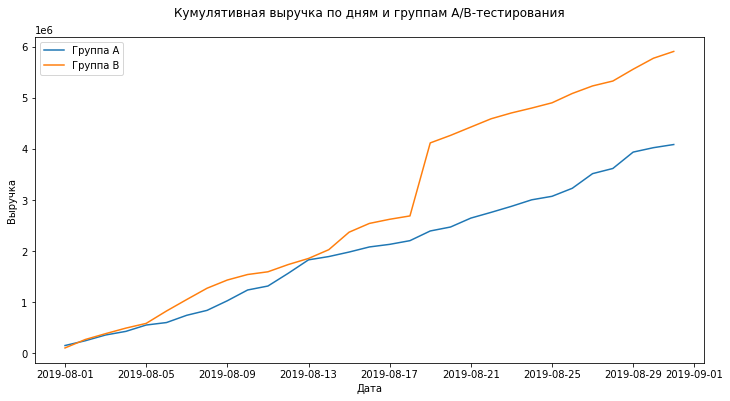

In [58]:
#График кумулятивной выручки
plt.figure(figsize=(12,6))
# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе А
c_rev_a = cumulative_data[cumulative_data['group']=='A'][['date','revenue', 'orders']]

# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе B
c_rev_b = cumulative_data[cumulative_data['group']=='B'][['date','revenue', 'orders']]


plt.plot(c_rev_a['date'], c_rev_a['revenue'], label='A')

plt.plot(c_rev_b['date'], c_rev_b['revenue'], label='B')

plt.title('Кумулятивная выручка по дням и группам A/B-тестирования', pad=20)

plt.xlabel('Дата')
plt.ylabel('Выручка')
plt.legend(['Группа А', 'Группа B'])
plt.show()

Можно видеть, что в обеих группах выручка плавно растёт, хотя в группе B она несколько больше. 13 августа выручки в обеих группах были почти одинаковыми, но после 17 августа выручка в группе В резко возросла (скачком), после чего разница в выручке между группами стала заметно существеннее (в пользу B-группы).

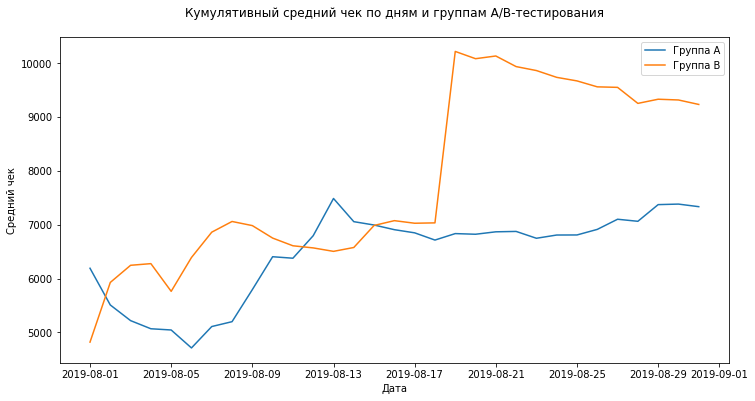

In [59]:
#График среднего чека
plt.figure(figsize=(12,6))
plt.plot(c_rev_a['date'], c_rev_a['revenue']/c_rev_a['orders'], label='A')
plt.plot(c_rev_b['date'], c_rev_b['revenue']/c_rev_b['orders'], label='B')


plt.title('Кумулятивный средний чек по дням и группам A/B-тестирования', pad=20)
plt.xlabel('Дата')
plt.ylabel('Средний чек')
plt.legend(['Группа А', 'Группа B'])
plt.show()

Виден резкий скачок 17 августа (как и на графике с выручкой). До этого средний чек большую часть времени был больше в групее B (за исключением краткосрочных периодов вроде 1 августа и 13 августа, когда средний чек в группе А немного превысил средний чек группы В). После 17 августа разница между средними чеками двух групп стала заметно существеннее, как и в случае с выручкой.

Вероятно, после 17 августа клиенты стали делать более дорогие заказы.

### Относительное изменение кумулятивного среднего чека группы B к группе A

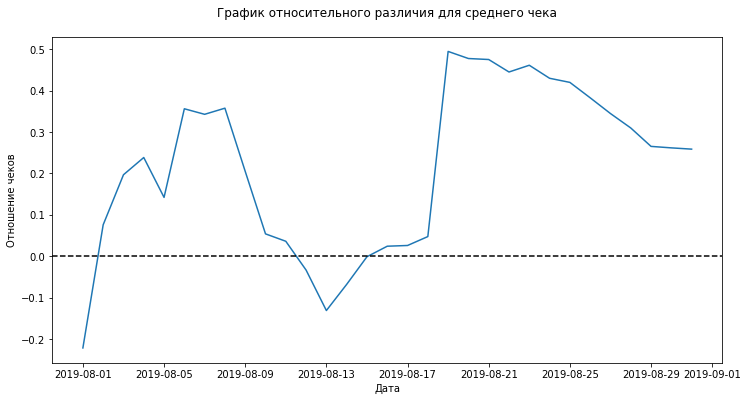

In [60]:
plt.figure(figsize=(12,6))
# собираем данные в одном датафрейме
full_c_rev = c_rev_a.merge(c_rev_b, left_on='date', right_on='date', how='left', suffixes=['A', 'B'])

# cтроим отношение средних чеков
plt.plot(full_c_rev['date'], (full_c_rev['revenueB']/full_c_rev['ordersB'])/(full_c_rev['revenueA']/full_c_rev['ordersA'])-1)

plt.title('График относительного различия для среднего чека', pad=20)
plt.xlabel('Дата')
plt.ylabel('Отношение чеков')
plt.axhline(y=0, color='black', linestyle='--')
plt.show()

Есть точки, в которых график "скачет"  -значит, есть выбросы и крупные заказы.

### Кумулятивная конверсия по группам и относительное изменение кумулятивной конверсии группы B к группе A.   

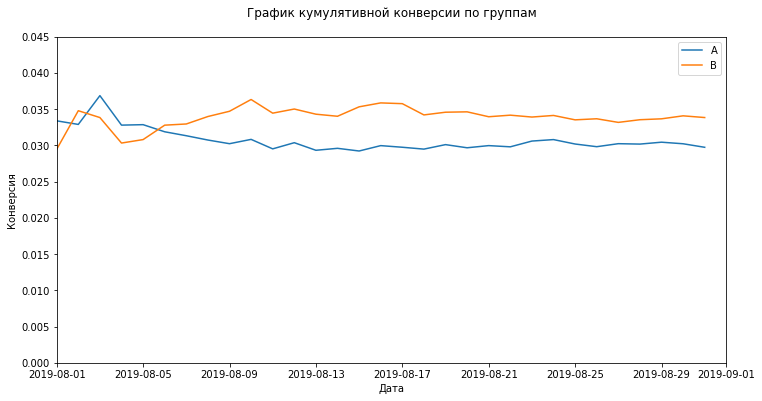

In [61]:
plt.figure(figsize=(12,6))

cumulative_data['conversion'] = cumulative_data['orders']/cumulative_data['visitors']

cumulative_data_a = cumulative_data[cumulative_data['group']=='A']
cumulative_data_b = cumulative_data[cumulative_data['group']=='B']

plt.plot(cumulative_data_a['date'], cumulative_data_a['conversion'], label='A')
plt.plot(cumulative_data_b['date'], cumulative_data_b['conversion'], label='B')
plt.title('График кумулятивной конверсии по группам', pad=20)
plt.xlabel('Дата')
plt.ylabel('Конверсия')
plt.legend()

plt.axis(["2019-08-01", '2019-09-01', 0, 0.045])
plt.show()

Конверсии двух групп были примерно равны в самом начале эксперимента. После 5 августа конверсия группы B с некоторыми колебаниями, но увеличилась и зафиксировалась. Конверсия группы А же наоборот, несколько просела.

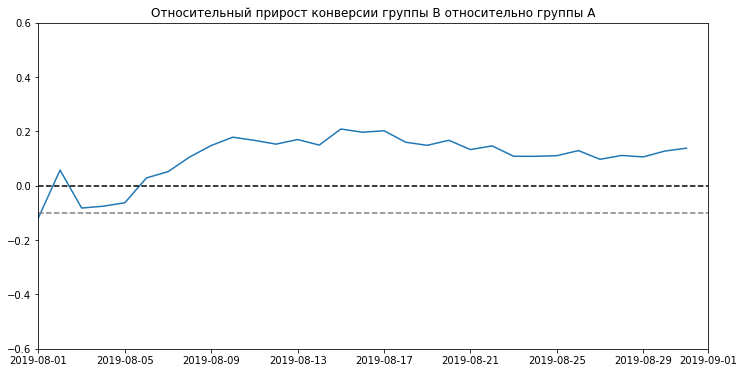

In [62]:
plt.figure(figsize=(12,6))
full_c_conv = cumulative_data_a[['date','conversion']].merge(cumulative_data_b[['date','conversion']], left_on='date', right_on='date', how='left', suffixes=['A', 'B'])

plt.plot(full_c_conv['date'], full_c_conv['conversionB']/full_c_conv['conversionA']-1)

plt.title('Относительный прирост конверсии группы B относительно группы A')
plt.axhline(y=0, color='black', linestyle='--')
plt.axhline(y=-0.1, color='grey', linestyle='--')
plt.axis(["2019-08-01", '2019-09-01', -0.6, 0.6])
plt.show()

Как видно и из этого, и из предыдущего графика: в начале теста группы были примерно на одном уровне, затем конверсия группы возросла, и стала превышать конверсию группы А.

### Точечный график количества заказов по пользователям и точечный график стоимостей заказов. Расчёт перцентилей.

Text(0.5, 0, 'Cтоимость')

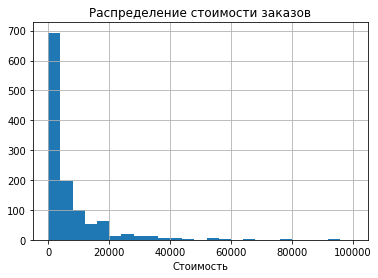

In [63]:
# Построим гистограмму распределения стоимости заказов
orders['revenue'].hist(bins = 25, range = (0, 100000))
plt.title('Распределение стоимости заказов')
plt.xlabel('Cтоимость')


 Есть достаточно дорогие, выбивающиеся заказы: около 60 000, 80 000 и 90 000.
 Построим точечную диаграмму:

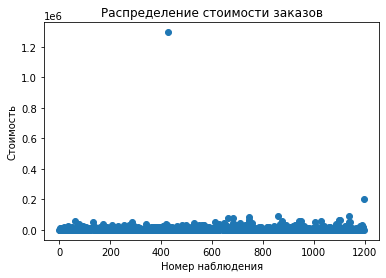

In [64]:
x_values = pd.Series(range(0,len(orders['revenue'])))
plt.scatter(x_values, orders['revenue'])
plt.title('Распределение стоимости заказов')
plt.xlabel('Номер наблюдения')
plt.ylabel('Cтоимость')
plt.show()

Явно выпадающие значения - около 200к и 1,2 миллиона. 

Подсчитаем  95-й и 99-й перцентили стоимости заказов:

In [65]:
np.percentile(orders['revenue'], [95, 99])

array([28000. , 58233.2])

Итак, не более 5% заказов дороже 28к. Не более 1% заказов дороже 58223.2. Будем считать границей 46к - среднее между 28к и 58к

Подсчитаем количество заказов по пользователям:

In [66]:
ord_by_us = orders.groupby('visitor_id', as_index=False).agg({'transaction_id' : pd.Series.nunique})
ord_by_us.columns = ['user_id','orders']
ord_by_us.sort_values(by='orders',ascending=False).head(10)

,user_id,orders
1023,4256040402,11
591,2458001652,11
569,2378935119,9
487,2038680547,8
44,199603092,5
744,3062433592,5
55,237748145,5
917,3803269165,5
299,1230306981,5
897,3717692402,5


Построим гистограмму и точечную диаграмму:

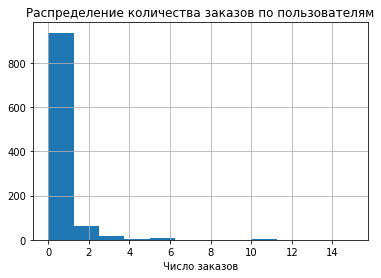

In [67]:
ord_by_us['orders'].hist(bins = 12, range = (0, 15))
plt.title('Распределение количества заказов по пользователям')
#plt.xlabel('Число заказов)
plt.xlabel('Число заказов') 
plt.show()

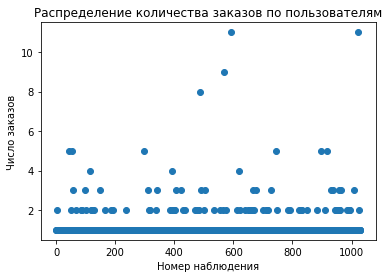

In [68]:
x_values = pd.Series(range(0,len(ord_by_us)))
plt.scatter(x_values, ord_by_us['orders'])
plt.title('Распределение количества заказов по пользователям')
plt.xlabel('Номер наблюдения')
plt.ylabel('Число заказов')
plt.show()

In [69]:
#Расчёт перцентилей
np.percentile(ord_by_us['orders'], [95, 99])

array([2., 4.])

Итак, не более 5% клиентов оформляли больше чем 2 заказа, 1% пользователей - более четырёх. Выберем границу в 3 заказа, т.к судя по точечной диаграммме, пренебречь клиентами с 2 заказами нельзя.

Итог: будем отсеивать тех пользователей, у которых больше трёх заказов или сумма заказа больше 46к. 

### Расчёт статистической значимости различий в конверсии и в среднем чеке заказа между группами по «сырым» данным   

Сформулируем гипотезы.

Нулевая гипотеза - Кол-во заказов на пользователя по сырым данным одинаковое.<br> 
Альтернативная гипотеза - Между кол-вом заказов на пользователя по сырым данным есть значимая разница.

In [70]:
# Кумулятивные данные по дням о количестве пользователей
visitors_day_a = visitors[visitors['group']=='A'][['date', 'visitors']]
visitors_day_b = visitors[visitors['group']=='B'][['date', 'visitors']]

visitors_day_a.columns = ['date', 'visitors_per_day_a']
visitors_day_b.columns = ['date', 'visitors_per_day_b']

visitors_day_сu_a = visitors_day_a.apply(
    lambda x: visitors_day_a[visitors_day_a['date'] <= x['date']].agg(
        {'date': 'max', 'visitors_per_day_a': 'sum'}
    ),
    axis=1,
)

visitors_day_сu_b = visitors_day_b.apply(
    lambda x: visitors_day_b[visitors_day_b['date'] <= x['date']].agg(
        {'date': 'max', 'visitors_per_day_b': 'sum'}
    ),
    axis=1,
)

visitors_day_сu_a.columns = ['date', 'visitors_cu_a']
visitors_day_сu_b.columns = ['date', 'visitors_cu_b']

In [71]:
# Кумулятивные данные по дням о количестве заказов и суммарной выручке
orders_day_a = (
    orders[orders['group'] == 'A'][['date', 'transaction_id', 'visitor_id', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transaction_id': pd.Series.nunique, 'revenue': 'sum'})
)

orders_day_b = (
    orders[orders['group'] == 'B'][['date', 'transaction_id', 'visitor_id', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transaction_id': pd.Series.nunique, 'revenue': 'sum'})
)

orders_day_a.columns = ['date', 'orders_per_day_a', 'revenue_per_day_a']
orders_day_b.columns = ['date', 'orders_per_day_b', 'revenue_per_day_b']


orders_day_cu_a = orders_day_a.apply(
    lambda x: orders_day_a[orders_day_a['date'] <= x['date']].agg(
        {'date': 'max', 'orders_per_day_a': 'sum', 'revenue_per_day_a': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])

orders_day_cu_b = orders_day_b.apply(
    lambda x: orders_day_b[orders_day_b['date'] <= x['date']].agg(
        {'date': 'max', 'orders_per_day_b': 'sum', 'revenue_per_day_b': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])

orders_day_cu_a.columns= ['date', 'orders_cu_a', 'revenue_cu_a']
orders_day_cu_b.columns = ['date', 'orders_cu_b', 'revenue_cu_b']

In [72]:
# Соберём данные в одну таблицу
data = (
    orders_day_a.merge(
        orders_day_b, left_on='date', right_on='date', how='left'
    )
    .merge(orders_day_cu_a, left_on='date', right_on='date', how='left')
    .merge(orders_day_cu_b, left_on='date', right_on='date', how='left')
    .merge(visitors_day_a, left_on='date', right_on='date', how='left')
    .merge(visitors_day_b, left_on='date', right_on='date', how='left')
    .merge(visitors_day_сu_a, left_on='date', right_on='date', how='left')
    .merge(visitors_day_сu_b, left_on='date', right_on='date', how='left')
)

data.head()

,date,orders_per_day_a,revenue_per_day_a,orders_per_day_b,revenue_per_day_b,orders_cu_a,revenue_cu_a,orders_cu_b,revenue_cu_b,visitors_per_day_a,visitors_per_day_b,visitors_cu_a,visitors_cu_b
0,2019-08-01,24,148579,21,101217,24,148579,21,101217,719,713,719,713
1,2019-08-02,20,93822,24,165531,44,242401,45,266748,619,581,1338,1294
2,2019-08-03,24,112473,16,114248,68,354874,61,380996,507,509,1845,1803
3,2019-08-04,16,70825,17,108571,84,425699,78,489567,717,770,2562,2573
4,2019-08-05,25,124218,23,92428,109,549917,101,581995,756,707,3318,3280


In [73]:
# Посчитаем число совершённых заказов для каждого пользователя, делавшего заказ хоть раз
ord_by_us_a = orders[orders['group']=='A'].groupby('visitor_id', as_index=False).agg({'transaction_id' : pd.Series.nunique})
ord_by_us_a.columns = ['visitor_id', 'orders']
 
ord_by_us_b = orders[orders['group']=='B'].groupby('visitor_id', as_index=False).agg({'transaction_id' : pd.Series.nunique})
ord_by_us_b.columns = ['visitor_id', 'orders']
 

Объявим переменные sampleA и sampleB, в которых пользователям из разных групп будет соответствовать количество заказов. Тем, кто ничего не заказал, будут соответствовать нули.

In [74]:
sampleA = pd.concat([ord_by_us_a['orders'],pd.Series(0, index=np.arange(visitors[visitors['group']=='A']['visitors'].sum() - len(ord_by_us_a['orders'])), name='orders')],axis=0)
sampleB = pd.concat([ord_by_us_b['orders'],pd.Series(0, index=np.arange(visitors[visitors['group']=='B']['visitors'].sum() - len(ord_by_us_b['orders'])), name='orders')],axis=0)
 
print("P-value: {0:.5f}".format(stats.mannwhitneyu(sampleA, sampleB)[1]))
print("Прирост конверсии: {0:.3f}".format(sampleB.mean()/sampleA.mean()-1))

P-value: 0.01679
Прирост конверсии: 0.138


 P-value меньше 0.05 - отвергаем нулевую гипотезу. Статистически значимые различия в конверсии между группами есть.
 Относительный прирост конверсии группы B = 13.8%

Нулевая гипотеза - Средний чек по сырым данным одинаковый.

Альтернативная гипотеза - Между средними чеками по сырым данным есть значимая разница.

In [75]:
#Cредний чек
print("P-value: {0:.3f}".format(stats.mannwhitneyu(orders[orders['group']=='A']['revenue'], orders[orders['group']=='B']['revenue'])[1]))
print("Прирост среднего чека:  {0:.3f}".format(orders[orders['group']=='B']['revenue'].mean()/orders[orders['group']=='A']['revenue'].mean()-1))

P-value: 0.729
Прирост среднего чека:  0.259


P-value больше 0.05 - нулевую гипотезу отвергнуть нельзя. Статистически значимых различий в среднем чеке между группами нет. 

Различие среднего чека между сегментами 25.9%

### Расчёт статистической значимости различий в конверсии и в среднем чеке заказа между группами по «очищенным» данным

In [76]:
# Отбросим пользователей, совершивших больше трёх заказо и пользователей, чья сумма заказа была больше 46к.

usersWithManyOrders = pd.concat(
    [
        ord_by_us_a[ord_by_us_a['orders'] > np.percentile(ord_by_us['orders'], [95, 99])[1]]['visitor_id'],
        ord_by_us_b[ord_by_us_b['orders'] > np.percentile(ord_by_us['orders'], [95, 99])[1]]['visitor_id'],
    ],
    axis=0,
)

usersWithExpensiveOrders = orders[orders['revenue'] > np.percentile(orders['revenue'], [95, 99])[1]]['visitor_id']

abnormalUsers = (
    pd.concat([usersWithManyOrders, usersWithExpensiveOrders], axis=0)
    .drop_duplicates()
    .sort_values()
)
print(abnormalUsers.shape)

(15,)


15 "аномальных"  пользователей. Отбросим их

In [77]:
sample_A_filtr = pd.concat(
    [
        ord_by_us_a[
            np.logical_not(ord_by_us_a['visitor_id'].isin(abnormalUsers))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitors_per_day_a'].sum() - len(ord_by_us_a['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

sample_B_filtr = pd.concat(
    [
        ord_by_us_b[
            np.logical_not(ord_by_us_b['visitor_id'].isin(abnormalUsers))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitors_per_day_b'].sum() - len(ord_by_us_b['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)
# Конверсия
print('P-value: {0:.5f}'.format(stats.mannwhitneyu(sample_A_filtr, sample_B_filtr)[1]))
print('Прирост конверсии: {0:.3f}'.format(sample_B_filtr.mean()/sample_A_filtr.mean()-1))

P-value: 0.01438
Прирост конверсии: 0.153


Как и для сырых данных,  p-value меньше 0.05 - отвергаем нулевую гипотезу. Статистически значимые различия в конверсии между группами есть.
 Относительный прирост конверсии группы B = 15.3%

In [78]:
print( "P-value: {0:.3f}".format(stats.mannwhitneyu(
    orders[np.logical_and(
        orders['group']=='A',
        np.logical_not(orders['visitor_id'].isin(abnormalUsers)))]['revenue'],
    orders[np.logical_and(
        orders['group']=='B',
        np.logical_not(orders['visitor_id'].isin(abnormalUsers)))]['revenue'])[1]))

print("Прирост среднего чека: {0:.3f}".format(
    orders[np.logical_and(orders['group']=='B',np.logical_not(orders['visitor_id'].isin(abnormalUsers)))]['revenue'].mean()/
    orders[np.logical_and(
        orders['group']=='A',
        np.logical_not(orders['visitor_id'].isin(abnormalUsers)))]['revenue'].mean() - 1))

P-value: 0.851
Прирост среднего чека: -0.006


P-value увеличился до 0.851 - много больше, чем 0.05. Нулевую гипотезу не отбрасываем.
Средний чек группы B стал немного меньше, чем у группы А -на 0.6% 


### Вывод
 По неочищенным данным: 
 - Конверсия:  p-value меньше 0.05 - отвергаем нулевую гипотезу. Статистически значимые различия в конверсии между группами есть. Относительный прирост конверсии группы B = 13.8%
 - Средний чек:  p-value больше 0.05 - нулевую гипотезу отвергнуть нельзя. Статистически значимых различий в среднем чеке между группами нет. Различие среднего чека между сегментами 25.9% в пользу группы B
 
По очищенным данным:
 - Конверсия: p-value меньше 0.05 - отвергаем нулевую гипотезу. Статистически значимые различия в конверсии между группами есть. Относительный прирост конверсии группы B = 15.3%
 - Средний чек: P-value увеличился до 0.775 - много больше, чем 0.05. Нулевую гипотезу не отбрасываем. Средний чек группы B превышает средний чек группы А на 3,8%
 

## Вывод по проекту

В результате выполнения проекта был изучен массив данных из крупного интернет-магазина: с параметрами гипотез  и с результатами A/B - теста.
- В ходе предобработки  данные были проверены на наличие пропусков и дубликатов (оные не обнаружены),  названия столбцов приведены к стилю snake,  данные в столбцах, связаннных с датой и временем, переведены в формат datetime

- В ходе рассмотрения гипотез наиболее перспективными были признаны следующие: будем считать наиболее перспективными следующие предложения: 
     - Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок
     - Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа
     - Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей
     - Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию
      
- В ходе анализа результатов А/B - теста было выяснено следующее:
     - В обеих группах как выручка, так и средний чек сначало плавно росли, хотя в группе B она несколько больше. После 17 августа выручка и средний чек в группе В резко возросли (скачком), после чего разница между группами стала заметно существеннее (в пользу B-группы).
     - Конверсии двух групп были примерно равны в самом начале эксперимента. После 5 августа конверсия группы B с некоторыми колебаниями, но увеличилась и зафиксировалась. Конверсия группы А же наоборот, несколько просела
     - В данных присутствуют выбросы. Были отброшены данные по пользователям, у которых больше трёх заказов или сумма заказа больше 46к.
     - По неочищенным данным:

        - Конверсия: p-value меньше 0.05 - отвергаем нулевую гипотезу. Статистически значимые различия в конверсии между группами есть. Относительный прирост конверсии группы B = 13.8%
        - Средний чек: p-value больше 0.05 - нулевую гипотезу отвергнуть нельзя. Статистически значимых различий в среднем чеке между группами нет. Различие среднего чека между сегментами 25.9% в пользу группы B
           
     - По очищенным данным:

       - Конверсия: p-value меньше 0.05 - отвергаем нулевую гипотезу. Статистически значимые различия в конверсии между группами есть. Относительный прирост конверсии группы B = 15.3%
       - Средний чек: P-value увеличился до 0
         
Исходя из вышеперечисленного, я бы предложила остановить тест и зафиксировать "победу" B-группы. 